In [1]:
import os
from multiprocessing import Process, Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import tqdm

from utils import release_mutations_from_two_seqs

In [2]:
PATH_TO_MULAL = '../data/omicron/mulal.fasta'
NSEQS = 133493

## 24 threads and 40 gb

In [3]:
%%time

reader = SeqIO.parse(PATH_TO_MULAL, 'fasta')
ref = next(reader)


def get_nums(rec):
    seq1, seq2 = str(ref.seq), str(rec.seq)
    mutations = release_mutations_from_two_seqs(seq1, seq2)
    mut_num = len(mutations)
    indel_num = len([x for x in mutations if x[2] == '-'])
    return mut_num, indel_num, (mutations, rec.name)


threads = 24
with Pool(threads) as p:
    nums = p.map(get_nums, reader)

CPU times: user 14.7 s, sys: 5.71 s, total: 20.4 s
Wall time: 25.2 s


In [4]:
len(nums)

133493

In [5]:
nums_pruned = [x for x in nums if x[0] < 400]
print(len(nums_pruned))

mut_distro = [x[0] for x in nums_pruned]
indel_distro = [x[1] for x in nums_pruned]

133037


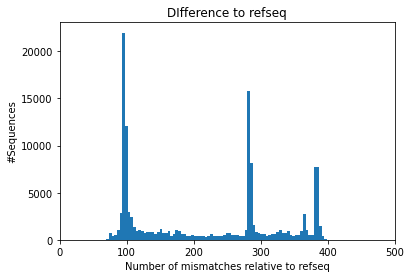

In [6]:
plt.hist(mut_distro, bins=90)
plt.xlim(0, 500)
plt.title("DIfference to refseq")
plt.xlabel("Number of mismatches relative to refseq")
plt.ylabel("#Sequences")
plt.savefig("../figures/diff_to_refseq.png")
plt.show()

### deletions

```
$ for n in 3 4 5 6 7 8 9; do echo $n; egrep "[ATGC]\-{$n}[ATGC]" -c data/mulal.fasta; done
3
360108
4
6794
5
2020
6
768892
7
1942
8
1371
9
413388
```
`egrep "[ATGC]\-{10,}[ATGC]" -c data/mulal.fasta` - 26459



####  9nt deletion and 6nt deletion are spread

In [7]:
51_418.92 / 2

25709.46

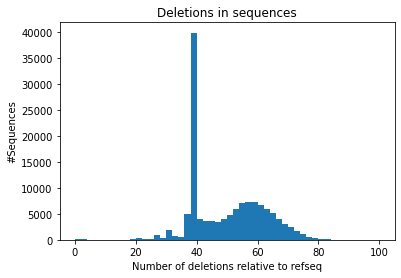

In [8]:
plt.hist(indel_distro, bins=50)
plt.title("Deletions in sequences")
plt.xlabel("Number of deletions relative to refseq")
plt.ylabel("#Sequences")
plt.savefig("../figures/dels_in_seqs.png")
plt.show()

## Compare with RefSeq

```
@ - поскольку у тебя уже есть омикроновый рефсек (те маркерные мутации, по которым Омикрона отличается от остальных линий), можешь сделать описательную статистику этих мутаций? FromTo (по сравнению с Вуханем например) на уровне нуклеотидов и аминокислот? Если на уровне аминокислот будет видно направление в нашу сторону - будет сильно!!!
```

In [9]:
omicron_refname = "EPI_ISL_6752027"

for _, _, (mut, name) in nums:
    if omicron_refname in name:
        break

In [10]:
mut[:3]

[(240, 'C', 'T', 'ttCgt', 'ttTgt'),
 (2831, 'A', 'G', 'gaAgt', 'gaGgt'),
 (3036, 'C', 'T', 'ttCta', 'ttTta')]

In [11]:
cols = [
    'Pos', 'RefNuc', 'GenName', 'GenType', 'CodonNumber', 'RefCodon', 
    'RefAa', 'NucInCodon', 'AltNuc', 'AltCodon', 'AltAa', 'AaSub', 
    'NeighL', 'NeighR', 'IsStem', 'SsPairs']

ref = pd.read_csv("../data/raw/ideal_table.csv", usecols=cols)

/home/kpotoh/sars-cov-2/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
Pos = [x[0] + 1 for x in mut]
refnuc = [x[1] for x in mut]
altnuc = [x[2] for x in mut]

obs_mut_label = [f"{x[0] + 1}_{x[1]}>{x[2]}" for x in mut]

In [13]:
obs_mut_label[:3]

['241_C>T', '2832_A>G', '3037_C>T']

In [14]:
ref.head(1722).tail()

,Pos,RefNuc,GenName,GenType,CodonNumber,RefCodon,RefAa,NucInCodon,AltNuc,AltCodon,AltAa,AaSub,NeighL,NeighR,IsStem,SsPairs
1717,573,C,ORF1ab,translated,103.0,ACA,T,2,G,AGA,R,NS,A,A,1.0,612.0
1718,573,C,ORF1ab,translated,103.0,ACA,T,2,A,AAA,K,NS,A,A,1.0,612.0
1719,574,A,ORF1ab,translated,103.0,ACA,T,3,T,ACT,T,S,C,C,1.0,611.0
1720,574,A,ORF1ab,translated,103.0,ACA,T,3,G,ACG,T,S,C,C,1.0,611.0
1721,574,A,ORF1ab,translated,103.0,ACA,T,3,C,ACC,T,S,C,C,1.0,611.0


In [15]:
mut_label = ref.apply(lambda x: f"{x.Pos}_{x.RefNuc}>{x.AltNuc}", axis=1)

In [16]:
omicron_muts = ref[mut_label.isin(obs_mut_label)]
omicron_muts.head()

,Pos,RefNuc,GenName,GenType,CodonNumber,RefCodon,RefAa,NucInCodon,AltNuc,AltCodon,AltAa,AaSub,NeighL,NeighR,IsStem,SsPairs
720,241,C,5UTR,untranslated,NaN,NaN,NaN,None,T,NaN,NaN,NaN,T,G,0.0,NaN
8494,2832,A,ORF1ab,translated,856.0,AAG,K,2,G,AGG,R,NS,A,G,NaN,NaN
9108,3037,C,ORF1ab,translated,924.0,TTC,F,3,T,TTT,F,S,T,T,NaN,NaN
16156,5386,T,ORF1ab,translated,1707.0,GCT,A,3,G,GCG,A,S,C,G,1.0,5330.0
17187,5730,C,ORF1ab,translated,1822.0,ACT,T,2,T,ATT,I,NS,A,T,NaN,NaN


### Omicron signature mutations

From the genomes available so far, the shared mutation profile is:

S: A67V, Δ69-70, T95I, G142D/Δ143-145, Δ211/L212I, ins214EPE, G339D, S371L, S373P,
S375F, K417N, N440K, G446S, S477N, T478K, E484A, Q493R, G496S, Q498R, N501Y,
Y505H, T547K, D614G, H655Y, N679K, P681H, N764K, D796Y, N856K, Q954H, N969K,
L981F.

NSP3: K38R, V1069I, Δ1265/L1266I, A1892T

NSP4: T492I; NSP5 – P132H

NSP6: Δ105-107, A189V

NSP12: P323L

NSP14: I42V

E: T9I

M: D3G, Q19E, A63T

N: P13L, Δ31-33, R203K, G204R

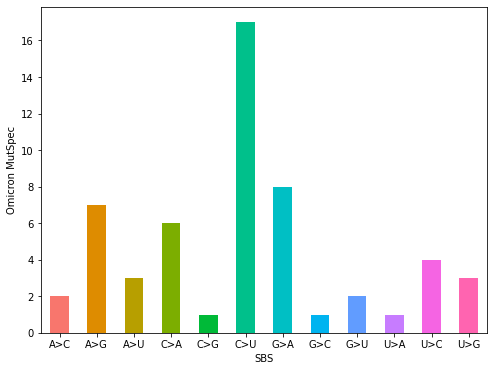

In [17]:
mutspec_omicron = (
        omicron_muts.RefNuc.str.replace("T", "U") + 
        ">" + 
        omicron_muts.AltNuc.str.replace("T", "U")
    ).value_counts().sort_index()

colors = [
    "#f8766d", "#de8c00", "#b79f00", "#7cae00", "#00ba38", "#00c08b", 
    "#00bfc4", "#00b4f0", "#619cff", "#c77cff", "#f564e3", "#ff64b0", 
]
colors = list(map(str.upper, colors))

mutspec_omicron.plot(kind="bar", color=colors, figsize=(8, 6))
plt.xticks(rotation=0)
plt.xlabel("SBS")
plt.ylabel("Omicron MutSpec")
plt.savefig("../figures/omicron_mutspec.svg")
plt.show()

In [18]:
# Code maps:
code3 = ["Ala", "Arg", "Asn", "Asp", "Cys", "Glu", "Gln", "Gly", "His", 
"Ile", "Leu", "Lys", "Met", "Phe", "Pro", "Ser", "Thr", "Trp", 
"Tyr", "Val"]
code1 = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", 
"M", "F", "P", "S", "T", "W", "Y", "V"]

aa_formatter = dict(zip(code1, code3))

In [33]:
aa_change_omicron = (
        omicron_muts[omicron_muts.RefAa != omicron_muts.AltAa].RefAa.map(aa_formatter) + 
        ">" + 
        omicron_muts[omicron_muts.RefAa != omicron_muts.AltAa].AltAa.map(aa_formatter)
    ).value_counts().sort_values(ascending=False).reset_index()

aa_change_omicron.columns = ["Mut", "Number"]

direction = [
    0, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, -1, 0, 1, 0, 0, 1, 0, 1, 0
]  # 1 means towards, 0 means without direction, -1 means against direction
aa_change_omicron["ExpDirection"] = direction

In [34]:
a = "All"
b = aa_change_omicron.Number.sum()
c = (aa_change_omicron.Number * aa_change_omicron.ExpDirection).sum()

aa_change_omicron = aa_change_omicron.append({
    "Mut": a, "Number": b, "ExpDirection":c
}, ignore_index=True)
aa_change_omicron.to_csv("../data/share/aa_change_omicron.tsv", index=None, sep="\t")

In [35]:
aa_change_omicron

,Mut,Number,ExpDirection
0,Asn>Lys,5,0
1,Thr>Ile,4,1
2,Pro>Leu,2,1
3,Gly>Ser,2,0
4,Asp>Gly,2,0
5,Gln>Arg,2,0
6,Ser>Pro,2,-1
7,Ile>Val,2,0
8,Pro>His,2,0
9,Ala>Thr,2,0


In [148]:
omicron_muts[["Pos", "GenName", "RefNuc", "AltNuc", "RefAa", "AltAa", "AaSub", "RefCodon", "AltCodon"]].sort_values("RefAa")

,Pos,GenName,RefNuc,AltNuc,RefAa,AltAa,AaSub,RefCodon,AltCodon
16156,5386,ORF1ab,T,G,A,A,S,GCT,GCG
80125,26709,M,G,A,A,T,NS,GCT,ACT
25177,8393,ORF1ab,G,A,A,T,NS,GCT,ACT
65283,21762,S,C,T,A,V,NS,GCT,GTT
79588,26530,M,A,G,D,G,NS,GAT,GGT
74997,25000,S,C,T,D,D,S,GAC,GAT
71841,23948,S,G,T,D,Y,NS,GAT,TAT
70207,23403,S,A,G,D,G,NS,GAT,GGT
69038,23013,S,A,C,E,A,NS,GAA,GCA
9108,3037,ORF1ab,C,T,F,F,S,TTC,TTT


In [16]:
import os
from multiprocessing import Process, Pool


def doubler(number):
    """
    Функция умножитель на два
    """
    result = number * 2
    proc = os.getpid()
    print('{0} doubled to {1} by process id: {2}'.format(
        number, result, proc))
 
 
if __name__ == '__main__':
    numbers = [5, 10, 15, 20, 25]
    procs = []
    
    for index, number in enumerate(numbers):
        proc = Process(target=doubler, args=(number,))
        procs.append(proc)
        proc.start()
    
    for proc in procs:
        proc.join()

5 doubled to 10 by process id: 9241210 doubled to 20 by process id: 92413

15 doubled to 30 by process id: 92419
20 doubled to 40 by process id: 92425
25 doubled to 50 by process id: 92430


In [17]:
def f(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(f, [1, 2, 3]))

[1, 4, 9]
